In [2]:
import numpy as np
from Utils import optimizer_utils as ou
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
dataset = '../Scans/2024-08-09/Quadscan.csv'
cam = 'cam4'

# dataset = '../Scans/2024-08-13/Quadscan.csv'
# cam = 'cam5'


# Read data, apply calibration
df = pd.read_csv(dataset)
df.xrms *= df.calibration
df.yrms *= df.calibration

# Group on quad currents for mean and std
grouped = df.groupby(['Q1', 'Q2', 'Q3'])
xdf = grouped.agg(
    spotsize_mean=('xrms', 'mean'),
    spotsize_std=('xrms', 'std'),
    ).reset_index()

ydf = grouped.agg(
    spotsize_mean=('yrms', 'mean'),
    spotsize_std=('yrms', 'std'),
    ).reset_index()

# Flip currents for y
ydf[['Q1', 'Q2', 'Q3']] = -1*ydf[['Q1', 'Q2', 'Q3']] 

# Remove datasets with std above threshold
std_threshold = 100
xdf = xdf[xdf.spotsize_std<std_threshold]
ydf = ydf[ydf.spotsize_std<std_threshold]

# Remove datasets far from focus
Q2_threshold = 1
xdf = xdf[xdf.Q2.abs()>Q2_threshold]
ydf = ydf[ydf.Q2.abs()>Q2_threshold]



In [4]:
# Specify beam energy
energy = 75e6 #eV

# Run optimizer (emittance scaled by 1e8)
bounds = [(0.1, 4), (-5, 5), (.01, 10)] 
x0 = [1, 0, 5]

xresult = minimize(lambda x: ou.errorfcn(x, xdf, energy, cam), x0, method='L-BFGS-B', bounds=bounds)
yresult = minimize(lambda x: ou.errorfcn(x, ydf, energy, cam), x0, method='L-BFGS-B', bounds=bounds)

print('----- Optimizer Result -----')
print(f'Xopt = {xresult.x}')
print(f'Yopt = {yresult.x}')
ou.print_results(xresult.x, energy, 'X')
ou.print_results(yresult.x, energy, 'Y')


----- Optimizer Result -----
Xopt = [ 1.68993666 -1.14078156  0.56832324]
Yopt = [ 4.         -4.59324957  0.11695996]
---------- X ----------
Emittance: 5.68e-08
Norm. Emittance: 8.34e-06
Beta Twiss: 1.69
Alpha Twiss: -1.14
---------- Y ----------
Emittance: 1.17e-08
Norm. Emittance: 1.72e-06
Beta Twiss: 4.00
Alpha Twiss: -4.59


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

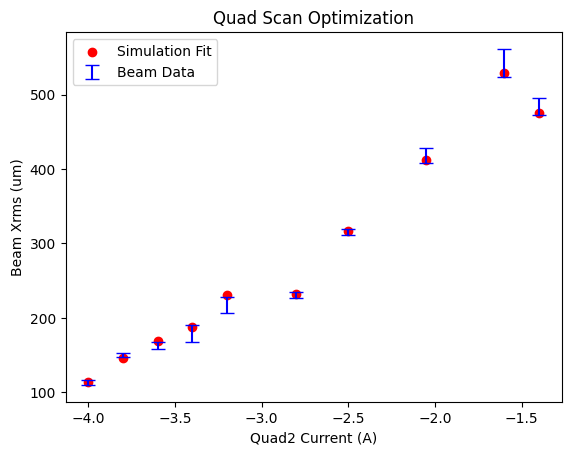

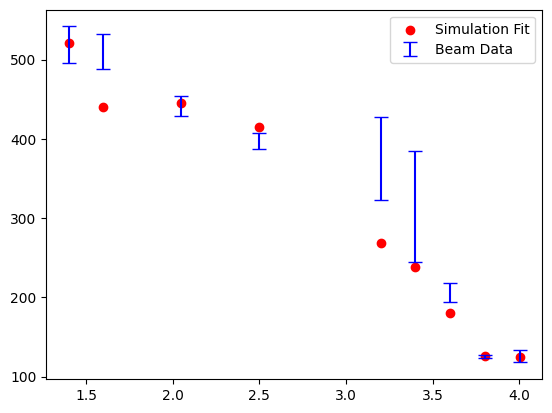

In [6]:
# Plot against data
x0 = [.3, -.3, .7]

fig, ax = ou.plot_fit_vs_data(xresult.x, xdf, energy, cam)
ax.set_xlabel('Quad2 Current (A)')
ax.set_ylabel('Beam Xrms (um)')
ax.set_title('Quad Scan Optimization')


ou.plot_fit_vs_data(yresult.x, ydf, energy, cam)
